In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/bigan_mnist')

models_prefix = 'models/'
images_prefix = 'images/'

if not os.path.exists(models_prefix):
  os.mkdir(models_prefix)

if not os.path.exists(images_prefix):
  os.mkdir(images_prefix)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import keras as ke
import numpy as np

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

Using TensorFlow backend.


In [3]:
epochs = 400
batch_size = 128
logging_step = 10

z_dim = 50
image_shape = (28, 28, 1)
hidden_layer_size = 1024

relu_leak = 0.2
init_lr = 0.0002
lr_decay = 0.01 # starting halfway through training

initializer = ke.initializers.RandomNormal(stddev=0.02)
regularizer = ke.regularizers.l2(2.5e-5)
optimizer = ke.optimizers.Adam(lr=init_lr, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
(X_train, y_train), (X_test, y_test) = ke.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255.
X_train = np.expand_dims(X_train, axis = 3)

X_test = X_test.astype(np.float32) / 255.
X_test = np.expand_dims(X_test, axis = 3)

In [0]:
def generator():
  model = ke.models.Sequential()
  
  model.add(ke.layers.Dense(hidden_layer_size, input_dim=z_dim,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.ReLU())
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.ReLU())
  model.add(ke.layers.BatchNormalization())
  
  model.add(ke.layers.Dense(np.prod(image_shape), activation='sigmoid',
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.Reshape(image_shape))
  
  return model

In [0]:
def encoder():
  model = ke.models.Sequential()
  model.add(ke.layers.Flatten(input_shape=image_shape))
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.LeakyReLU(alpha=relu_leak))
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.LeakyReLU(alpha=relu_leak))
  model.add(ke.layers.BatchNormalization())
  
  model.add(ke.layers.Dense(z_dim,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))

  return model

In [0]:
def discriminator():
  z_ = ke.layers.Input(shape=(z_dim,))
  image_ = ke.layers.Input(shape=image_shape)
  input_ = ke.layers.concatenate([z_, ke.layers.Flatten()(image_)])

  model = ke.layers.Dense(hidden_layer_size,
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(input_)
  
  model = ke.layers.LeakyReLU(alpha=relu_leak)(model)
  
  model = ke.layers.Dense(hidden_layer_size,
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(model)
  
  model = ke.layers.LeakyReLU(alpha=relu_leak)(model)
  
  output = ke.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(model)

  return ke.models.Model([z_, image_], output)

In [0]:
def build_bigan():
  D = discriminator()
  D.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  D.trainable = False
  
  G = generator()
  z = ke.layers.Input(shape=(z_dim, ))
  image_ = G(z)

  E = encoder()
  image = ke.layers.Input(shape=image_shape)
  z_ = E(image)
  
  D_real = D([z_, image])
  D_fake = D([z, image_])
  
  BiGAN = ke.models.Model([z, image], [D_real, D_fake])
  BiGAN.compile(optimizer=optimizer, loss='binary_crossentropy')
  
  return G, E, D, BiGAN

In [0]:
def load_bigan(G, E, D):
  z = ke.layers.Input(shape=(z_dim, ))
  image_ = G(z)
  
  image = ke.layers.Input(shape=image_shape)
  z_ = E(image)
  
  D_real = D([z_, image])
  D_fake = D([z, image_])
  
  BiGAN = ke.models.Model([z, image], [D_real, D_fake])
  BiGAN.compile(optimizer=optimizer, loss='binary_crossentropy')
  
  return BiGAN

In [10]:
LOAD_MODELS = 1

if LOAD_MODELS:
  G = ke.models.load_model(models_prefix + 'G.h5')
  E = ke.models.load_model(models_prefix + 'E.h5')
  D = ke.models.load_model(models_prefix + 'D.h5')
  BiGAN = load_bigan(G, E, D)
else:
  G, E, D, BiGAN = build_bigan()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
def qualitative_results(n = 20):
  z = np.random.uniform(-1, 1, (n, z_dim))
  generated = G.predict(z)
  
  real_images = X_test[np.random.choice(len(X_test), n)]
  latent_codes = E.predict(real_images)
  reconstructions = G.predict(latent_codes)
  
  fig, axs = plt.subplots(3, n)
  
  for i in range(n):
    axs[0, i].imshow(generated[i, :, :, 0], cmap='gray')
    axs[1, i].imshow(real_images[i, :, :, 0], cmap='gray')
    axs[2, i].imshow(reconstructions[i, :, :, 0], cmap='gray')
    for j in range(3):
      axs[j, i].axis('off')
  
  return fig

In [0]:
def train():
  batches = int(len(X_train) / batch_size)
  
  ones = np.ones(batch_size)
  zeros = np.zeros(batch_size)

  for epoch in range(epochs):
    for batch in range(batches):
      z = np.random.uniform(-1, 1, (batch_size, z_dim))
      images = X_train[np.random.choice(len(X_train), batch_size)]
      
      z_ = E.predict(images)
      images_ = G.predict(z)

      loss_D_fake = D.train_on_batch([z, images_], zeros)
      loss_D_real = D.train_on_batch([z_, images], ones)
      loss_E_G = BiGAN.train_on_batch([z, images], [zeros, ones])[0]
    
    if epoch > epochs/2:
      ke.backend.set_value(optimizer.lr, init_lr * (lr_decay ** (epoch * 2. / epochs - 1.)))
      
    if epoch % logging_step == 0:
      D_loss = (loss_D_fake[0] + loss_D_real[0]) * 0.5
      acc_fake = loss_D_fake[1] * 100.0
      acc_real = loss_D_real[1] * 100.0
      
      print('[Epoch {}] (Disc loss: {:.2f}, acc_fake: {:.1f}%, acc_real: {:.1f}%) (E_G loss: {:.2f})'.
            format(epoch, D_loss, acc_fake, acc_real, loss_E_G))
      
      fig = qualitative_results()
      fig.savefig('images/{}.png'.format(epoch))
      plt.close()

In [0]:
TRAIN_MODELS = 0

if TRAIN_MODELS:
  train()

In [0]:
SAVE_MODELS = 0

if SAVE_MODELS:
  G.save(models_prefix + 'G.h5')
  E.save(models_prefix + 'E.h5')
  D.save(models_prefix + 'D.h5')

In [0]:
def ONN_accuracy():
  latent_codes = E.predict(X_test)
  ONN = NearestNeighbors(n_neighbors=2, algorithm='brute').fit(latent_codes)
  
  _, indices = ONN.kneighbors(latent_codes)
  results = (y_test == y_test[indices[:,1]])
  
  print('One Nearest Neighbors (1NN) classification accuracy: {}%'.format(100. * np.mean(results)))

In [0]:
def TSNE_embedding(X, y, n):
  latent_codes = E.predict(X[:n])
  embedding = TSNE().fit_transform(latent_codes)
  
  ax = plt.subplot(1, 1, 1)
  ax.scatter(embedding[:, 0], embedding[:, 1], c=y[:n], cmap=plt.cm.get_cmap('RdYlBu'))
  ax.axis('off')
  
  plt.show()

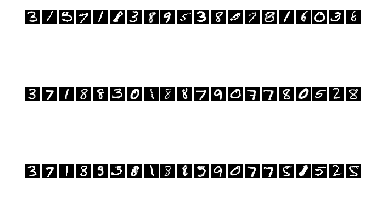

One Nearest Neighbors (1NN) classification accuracy: 93.75%


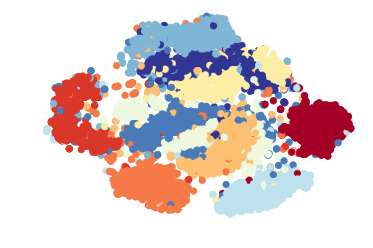

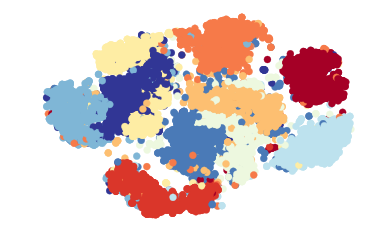

In [17]:
EVALUATE_MODELS = 1

if EVALUATE_MODELS:
  qualitative_results()
  plt.show()
  
  ONN_accuracy()
  
  TSNE_embedding(X_train, y_train, len(y_test))
  TSNE_embedding(X_test, y_test, len(y_test))